# Models

## Imports

In [122]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [123]:
# Operations on the GPU if available
if torch.cuda.is_available():
    print("The code is running on GPU.")
else:
    print("The code is running on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code is running on CPU.


In [124]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Functions

In [192]:
class Dataset(data.Dataset):
    """Creates a Dataset depending on the given matrices.
    
    Attributes:
        inputs(np.ndarray): Sliced matrix of inputs.
        p_type(np.ndarray): Sliced matrix of point type (from inputs).
        targets(np.ndarray): Sliced matrix of targets.
        n_u(int): Number of data points.
        n_f(int): Number of collocation points.
    
    Returns:
        X(np.ndarray): Input observation at idx.
        y(np.ndarray): Target observation at idx.
        p_type(np.ndarray): Point type at idx
    """
    def __init__(self, X_u, X_f, y, data_params, collocation=True, train=True, split=0.95):
        """Inits the Dataset, depends on collocation flag.
        
        Args:
        inputs(np.ndarray): Matrix of inputs.
        targets(np.ndarray): Matrix of targets.
        data_params(Dict): Includes the parameters of the dataset.
        collocation(bool): Indicates if the matrices should be sliced _
            to only include data points or also collocation points.
        """
        
        # Unpack parameters
        self.n_u = data_params['n_data']
        self.n_f = data_params['n_collocation']
        self.seed = data_params['seed']
        
        X_train, X_test, y_train, y_test = train_test_split(X_u, y,
                                                            train_size=split,
                                                            random_state=self.seed)
        
        idx = np.random.choice(X_train.shape[0], self.n_u, replace=False)
        X_u_train = X_train[idx, 0:2]
        p_train = X_train[idx, -1].reshape((-1,1))
        y_train = y_train[idx, :]
        
        if collocation:
            idx = np.random.choice(X_f.shape[0], self.n_f, replace=False)
            X_train = np.vstack((X_u_train, X_f[idx, 0:2]))
            p_train = np.vstack((p_train, X_f[idx, -1].reshape((-1,1))))
            y_train = np.vstack((y_train, np.zeros((self.n_f, 1))))
        else:
            X_train = X_u_train
        
        if train:
            self.inputs = X_train
            self.p_type = p_train
            self.targets = y_train
        else:
            self.inputs = X_test[:, 0:2]
            self.p_type = X_test[:, -1].reshape((-1,1))
            self.targets = y_test

    def __len__(self):
        """Returns the size of the dataset."""
        return len(self.targets)

    def __getitem__(self, idx):
        """Retrieve inputs and targets at the given index."""
        X = torch.Tensor(self.inputs[idx])
        p_type = torch.Tensor(self.p_type[idx])
        y = torch.Tensor(self.targets[idx])

        return X, p_type, y

In [193]:
def get_activation(self, name):
    """Matches the activation function name with the actual Pytorch function.

    Args:
        name(str): Name of the activation function.

    Returns:
        act(fun): Pytorch activation function.
    """

    activations = {'tanh': nn.Tanh(),
                   'relu': nn.ReLU(inplace=True),
                   'leakyrelu': nn.LeakyReLU(inplace=True),
                   'sigmoid': nn.Sigmoid()
                  }

    if name.lower() in activations:
        return activations[name.lower()]
    else: 
        raise ValueError(f'Activation function "{name}" not implemented, available activations are {list(activations.keys())}.')

def get_loss(self, name):
    """Matches the loss function name with the actual Pytorch function.

    Args:
        name(str): Name of the loss function.

    Returns:
        loss(fun): Pytorch losss function.
    """

    loss_funs = {'MSE': nn.MSELoss(),
                 'MAE': nn.L1Loss(),
                }

    if name in loss_funs:
        return loss_funs[name]
    else: 
        raise ValueError(f'Loss function "{name}" not implemented, available loss functions are {list(loss_funs.keys())}.')

In [194]:
class NN(nn.Module):
    """Feed-Forward Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    
    def __init__(self, nn_params):
        """Inits the NN architecture with given parameters."""
        super().__init__()
        
        # Unpack parameters
        self.layers = nn_params['layers']
        self.act_name = nn_params['act_name']
        self.loss_name = nn_params['loss_name']
        
        # Define parameters
        self.depth = len(layers) - 1
        
        # Create architecture
        self.nn = nn.Sequential()
        
        # Add layers until output layer
        for n in range(self.depth - 1):
            self.nn.add_module(f"layer_{n}", nn.Linear(layers[n], layers[n + 1]))
            self.nn.add_module(f"act_{n}", nn.Tanh())
        
        # Output layer (excluding activation)
        self.nn.add_module(f"layer_{n + 1}", nn.Linear(layers[n + 1], layers[n + 2]))
        
        self.loss_fun = nn.MSELoss()
        
        # Weight initialization (already Kaiming uniform)
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight)
#                 nn.init.constant_(m.bias, 0)

    def forward_nn(self, x):
        """Feed-forward the inputs through the network."""
        return self.nn(x)
    
    def loss_nn(self, y_hat, y):
        return self.loss_fun(y_hat, y)

In [296]:
class PINN(NN):
    """Physics-Informed Neural Network (NN).

    Attributes:
        layers(list): Architecture of the NN.
        act_name(str): Activation function to use after each layer.
        depth(int): Maximum depth of the NN.
        nn(nn.Sequential): Sequential container of the NN.
    """
    def __init__(self, nn_params, data_params):
        super().__init__(nn_params)
        
        # Unpack equation parameters
        self.m = torch.Tensor([data_params['inertia']])
        self.d = torch.Tensor([data_params['damping']])
        self.B = torch.Tensor([data_params['susceptance']])

    def forward_pinn(self, x):
        
        x.requires_grad_(True)
        
        # Forward pass
        u = self.forward_nn(x)
        
        # First derivative
        dudx = self.gradients(u, x)[0]
        dudt = dudx[:, 1]
        
        # Second derivative
        dudxx = self.gradients(dudx, x)[0]
        dudtt = dudxx[:, 1]
        
        #u.detach_()

        # Physics term
        f = self.m * dudtt + self.d * dudt + self.B * torch.sin(u) - x[:, 0]
        #print(dudx)
        #print(dudt)
        #print(dudxx)
        #print(dudtt)
        return u, f
    
    def loss_pinn(self, u_hat, u, p_type, f, w1=1, w2=1):

        # Angle loss
        #print("u:", u)
        u_filtered = u_hat * p_type
        #print("u_filtered:",u_filtered)
        MSE_u = self.loss_fun(u_filtered, u)
        #print("MSE_u:", MSE_u)

        # Physics loss
        MSE_f = torch.mean(f**2)
        #print("MSE_f:", MSE_f)

        # Total loss
        MSE = w1*MSE_u + w2*MSE_f
        
        return MSE_u, MSE_f, MSE

    def gradients(self, outputs, inputs):
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

In [297]:
def train_NN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': []
               }
    
    train_loss = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            Y_hat = model.forward_nn(X_train)

            # Compute the loss
            loss = model.loss_nn(Y_hat, Y_train)

            # Backward pass through the network
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Save train loss
            train_loss.append(loss.data.numpy())

        if epoch % 500 == 0:

            # Activate evaluation mode
            model.eval()

            test_loss = []

            for (X_test, p_type, Y_test) in test_loader:

                X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)

                with torch.no_grad():

                    Y_hat = model.forward_nn(X_test)

                    test_loss.append(model.loss_nn(Y_hat, Y_test).cpu().item())

            out_dict['test_loss'].append(np.mean(test_loss))
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        
    return out_dict

In [355]:
def train_PINN(model, train_loader, test_loader, nn_params, data_params):
    
    optim = nn_params['optim']
    
    # Initialize the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    n_data = data_params['n_data']
    n_collocation = data_params['n_collocation']
    w2 = n_data/(n_data+n_collocation)
    
    # Output dictionary
    out_dict = {'train_loss': [],
                'test_loss': [],
                'MSE_u': [],
                'MSE_f': []
               }
    
    train_loss = []
    loss_u_e = []
    loss_f_e = []
    
    for epoch in tqdm(range(n_epochs), unit='epoch'):
        
        # Activate train mode
        model.train()
        
        for (X_train, p_type, Y_train) in train_loader:
            
            X_train, p_type, Y_train = X_train.to(device), p_type.to(device), Y_train.to(device)
            
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass
            u, f = model.forward_pinn(X_train)

            # Compute the loss
            loss_u, loss_f, loss = model.loss_pinn(u, Y_train, p_type, f, w2)
            
            # Backward pass through the network
            loss.backward()

            # Update the weights
            optimizer.step()
        
            # Save losses
            loss_u_e.append(loss_u.data.numpy())
            loss_f_e.append(loss_f.data.numpy())
            train_loss.append(loss.data.numpy())
        
        if epoch % 500 == 0:
            
            # Activate evaluation mode
            model.eval()

            test_loss = []

            for (X_test, p_type, Y_test) in test_loader:

                X_test, p_type, Y_test = X_test.to(device), p_type.to(device), Y_test.to(device)
                
                with torch.no_grad():

                    u = model.forward_nn(X_test)
                
                    test_loss.append(model.loss_nn(u, Y_test).cpu().item())
            
            out_dict['test_loss'].append(np.mean(test_loss))
        
        # Pack epoch losses
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['MSE_u'].append(np.mean(loss_u_e))
        out_dict['MSE_f'].append(np.mean(loss_f_e))
        
    return out_dict

In [356]:
def plot_loss(results):
    plt.plot(results['train_loss'], label='train')
    plt.plot(results['test_loss'], label='test')
   # plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

## Parameters

In [357]:
# Data parameters
n_data = 101 # number of data points
n_collocation = 8000 # number of collocation points

m = 0.15 # angular inertia
d = 0.15 # damping coefficient
B = 0.2 # susceptance [pu]
delta_0 = 0 # initial angle [rad]
omega_0 = 0 # initial angular speed [rad/s]

p_min = 0.08 # minimum power [pu]
p_max = 0.18 # maximum power [pu]
p_span = (p_min, p_max)

t_min = 0 # [seconds]
t_max = 10 # [seconds]
t_span = (t_min, t_max)

seed = 123

data_params = {'n_data': n_data,
               'n_collocation': n_collocation,
               'inertia': m,
               'damping': d,
               'susceptance': B,
               'delta_0': delta_0,
               'omega_0': omega_0,
               'p_span': p_span,
               't_span': t_span,
               'seed': seed
              }

In [358]:
# NN parameters
lr = 0.001
n_epochs = 100
batch_size = 500
optim = 'Adam' # SGD, LFBGS
loss = 'MSE' # MAE
activation = 'tanh'
layers = [2, 20, 20, 20, 1] # NN architecture

nn_params = {'learning_rate': lr,
             'n_epochs': n_epochs,
             'optim': optim,
             'loss_name': loss,
             'act_name': activation,
             'layers': layers
            }

## Data

In [359]:
with np.load('../data/data.npz') as data_npz:
    X_u = data_npz['X_u']
    X_f = data_npz['X_f']
    y_delta = data_npz['y_delta']
    y_omega = data_npz['y_omega']

In [360]:
print(f"Input shape: {X_u.shape}\n"
      f"Input shape: {X_f.shape}\n"
      f"Output shape: {y_delta.shape}\n"
      f"Output shape: {y_omega.shape}")

Input shape: (10201, 3)
Input shape: (8000, 3)
Output shape: (10201, 1)
Output shape: (10201, 1)


In [361]:
# Create datasets
train_short = Dataset(X_u, X_f, y_delta, data_params, collocation=False)
train_long = Dataset(X_u, X_f, y_delta, data_params)
test = Dataset(X_u, X_f, y_delta, data_params, train=False)

# Create train and test loaders
train_loader_short = data.DataLoader(train_short, batch_size=batch_size, shuffle=True)
train_loader_long = data.DataLoader(train_long, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test, batch_size=batch_size, shuffle=False) # num_workers=1

In [362]:
train_short.inputs.shape

(101, 2)

In [363]:
train_long.inputs.shape

(8101, 2)

In [364]:
test.inputs.shape

(511, 2)

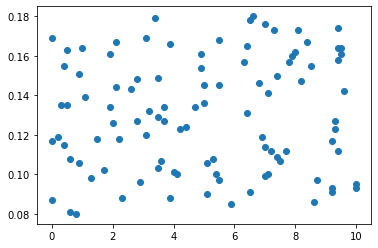

In [365]:
plt.scatter(train_short.inputs[:,1], train_short.inputs[:,0])

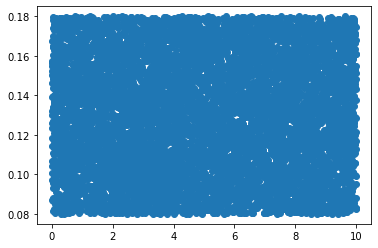

In [366]:
plt.scatter(train_long.inputs[:,1], train_long.inputs[:,0])

## NN

In [265]:
# Initialize model
model_NN = NN(nn_params)

# To GPU or CPU
model_NN.to(device)

NN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (act_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss_fun): MSELoss()
)

In [266]:
#%lprun -f train_NN train_NN(model_NN, train_loader_short, test_loader, nn_params, data_params)

In [267]:
# Train
results_NNshort = train_NN(model_NN, train_loader_short, test_loader, nn_params, data_params)

100%|██████████| 10000/10000 [01:35<00:00, 104.17epoch/s]


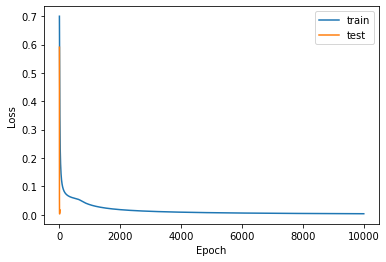

In [268]:
plot_loss(results_NNshort)

In [269]:
results_NNshort['test_loss']

[0.5905410349369049,
 0.05497492104768753,
 0.03536599618382752,
 0.01222960778977722,
 0.004605675232596695,
 0.003417360596358776,
 0.003247890272177756,
 0.0031475945143029094,
 0.0030642133788205683,
 0.0031733840296510607,
 0.003676524051115848,
 0.004646079236408696,
 0.005998198528686771,
 0.007524205750087276,
 0.009083204770831799,
 0.010713218198361574,
 0.012371256450933288,
 0.014023791070940206,
 0.015450760911335237,
 0.016748982889112085]

In [324]:
def plot_prediction(idx, model):
    idx=20
    preds = []
    for x in X_u[idx*n_data:idx*n_data+n_data, 0:2]:
        x = torch.Tensor(x)
        preds.append(model.nn.forward(x).item())

    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], y_delta[idx*n_data:idx*n_data+n_data], label="exact")
    plt.plot(X_u[idx*n_data:idx*n_data+n_data, 1], preds, label="prediction")
    plt.xlabel("Time [s]")
    plt.ylabel("δ [rad]")
    plt.legend()

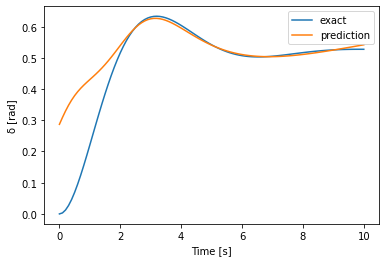

In [325]:
plot_prediction(10, model_NN)

## PINN

In [367]:
# Initialize model
model_PINN = PINN(nn_params, data_params)

# To GPU or CPU
model_PINN.to(device)

PINN(
  (nn): Sequential(
    (layer_0): Linear(in_features=2, out_features=20, bias=True)
    (act_0): Tanh()
    (layer_1): Linear(in_features=20, out_features=20, bias=True)
    (act_1): Tanh()
    (layer_2): Linear(in_features=20, out_features=20, bias=True)
    (act_2): Tanh()
    (layer_3): Linear(in_features=20, out_features=1, bias=True)
  )
  (loss_fun): MSELoss()
)

In [368]:
results_PINNlong = train_PINN(model_PINN, train_loader_long, test_loader, nn_params, data_params)

100%|██████████| 100/100 [01:07<00:00,  1.48epoch/s]


In [351]:
%lprun -f train_PINN train_PINN(model_PINN, train_loader_long, test_loader, nn_params, data_params)

100%|██████████| 100/100 [01:23<00:00,  1.19epoch/s]


Timer unit: 1e-06 s

Total time: 83.7652 s
File: <ipython-input-339-480869f14150>
Function: train_PINN at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train_PINN(model, train_loader, test_loader, nn_params, data_params):
     2                                               
     3         1          4.0      4.0      0.0      optim = nn_params['optim']
     4                                               
     5                                               # Initialize the optimizer
     6         1         14.0     14.0      0.0      if optim == 'SGD':
     7                                                   optimizer = torch.optim.SGD(model.parameters(), lr=lr)
     8         1          3.0      3.0      0.0      elif optim == 'Adam':
     9         1        574.0    574.0      0.0          optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    10                                                   
  

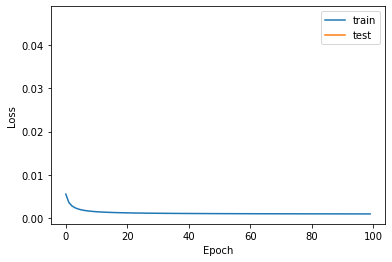

In [369]:
plot_loss(results_PINNlong)

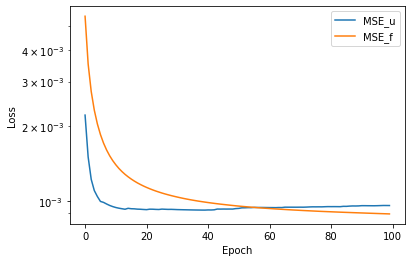

In [370]:
plt.plot(results_PINNlong['MSE_u'], label='MSE_u')
plt.plot(results_PINNlong['MSE_f'], label='MSE_f')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [373]:
results_PINNlong['test_loss'][-1]

0.04674459621310234

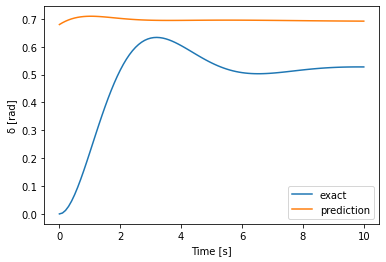

In [374]:
plot_prediction(10, model_PINN)

## BPINN

### Bayes rule

Likelihood: $$p(D|\theta)$$
Prior: $$p(\theta)$$
Posterior: $$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)} = \frac{p(D|\theta)p(\theta)}{\sum p(D|\theta)p(\theta)d\theta}$$
MCMC: $$p(y^*|D) = \mathbb{E}_{p(\theta|D)}p(y^*|\theta) \approx \frac{1}{K} \sum_{k=1}^{K} p(y^*|\theta^k)$$
VI: $$q(z)$$
$$\mathbb{KL}(q(z)||p(y|x)) = \mathbb{E}_q\left[log\frac{q(z)}{p(y|x)}\right]$$
Aleatoric (data) and Epistemic (knowledge or model) Uncertainty

In [20]:
from torchvision import datasets, transforms

In [25]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [43]:
from matplotlib import colors

In [21]:
class NN(nn.Module):
	
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to mnist-data/MNIST/raw


Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist-data/MNIST/raw



Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist-data/MNIST/raw


Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist-data/MNIST/raw
Processing...
Done!


/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629434582/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [28]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [29]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [30]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [31]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/home/jorge/miniconda3/envs/ml4ps_pyro/lib/python3.8/site-packages/pyro/primitives.py:404: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


Epoch  0  Loss  2091.2233217416047
Epoch  1  Loss  372.31008965975445
Epoch  2  Loss  159.50644796849886
Epoch  3  Loss  111.19572409764926
Epoch  4  Loss  96.2107744321982


In [39]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == np.array(labels)).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [34]:
labels

tensor([8, 4, 0, 2, 7, 8, 0, 6, 9, 6, 1, 4, 4, 2, 5, 4, 9, 3, 8, 0, 6, 2, 8, 9,
        1, 7, 5, 7, 3, 8, 3, 0, 0, 4, 7, 5, 1, 4, 6, 9, 9, 6, 7, 1, 1, 4, 1, 1,
        8, 3, 9, 2, 7, 3, 8, 6, 6, 9, 0, 0, 8, 1, 7, 8, 1, 0, 1, 2, 1, 2, 2, 4,
        8, 5, 7, 9, 0, 8, 7, 2, 0, 3, 0, 5, 6, 8, 0, 0, 9, 1, 8, 8, 0, 0, 6, 1,
        7, 3, 1, 8, 5, 0, 6, 1, 3, 6, 0, 2, 2, 7, 5, 1, 0, 1, 8, 4, 1, 7, 7, 2,
        3, 7, 9, 9, 6, 9, 9, 1])

In [38]:
(predicted == np.array(labels)).sum()

122

In [44]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [41]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1269
Accuracy when made predictions: 95 %


Real:  4


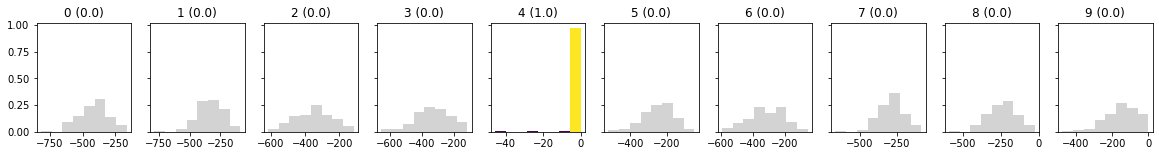

Correct


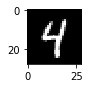

Real:  5


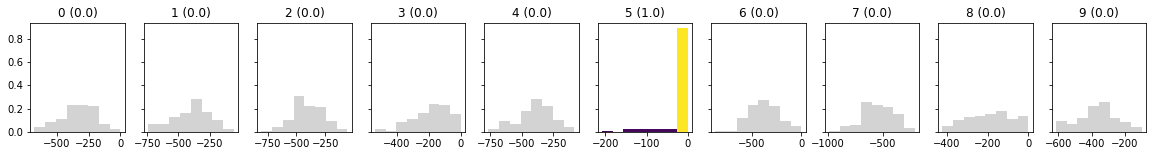

Correct


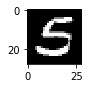

Real:  2


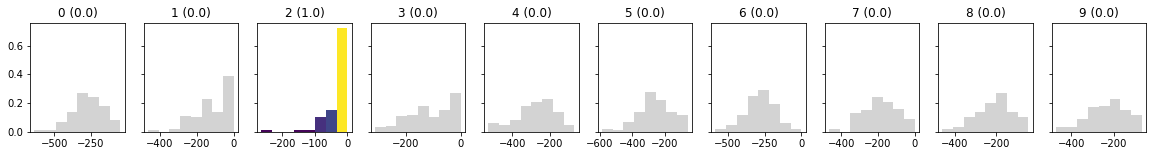

Correct


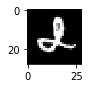

Real:  9


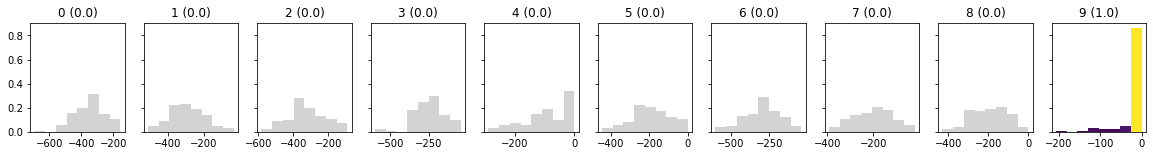

Correct


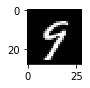

Real:  6


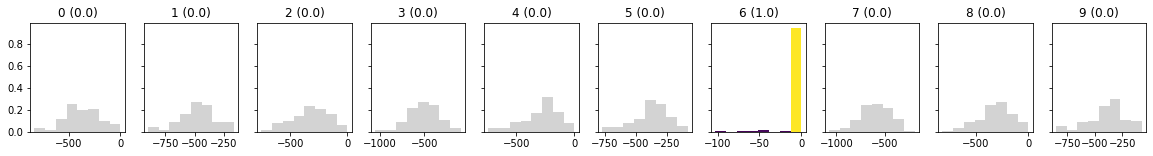

Correct


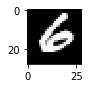

Summary
Total images:  5
Predicted for:  5
Accuracy when predicted:  1.0


(5, 5.0, 5)

In [46]:
# Testing numbers
dataiter = iter(test_loader)
images, labels = dataiter.next()

test_batch(images[:5], labels[:5])

Real:  5


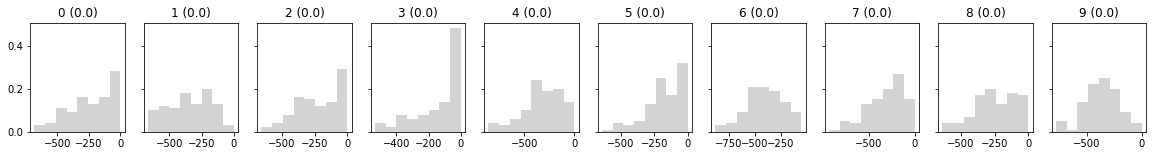

Undecided.


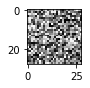

Real:  0


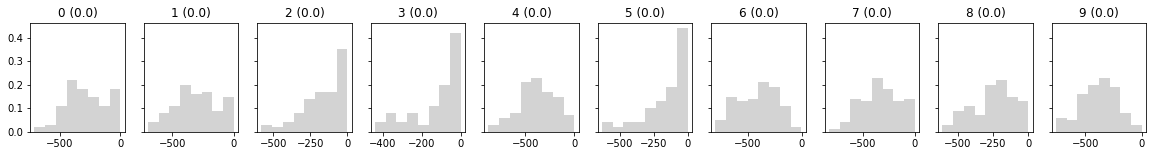

Undecided.


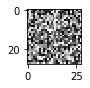

Real:  9


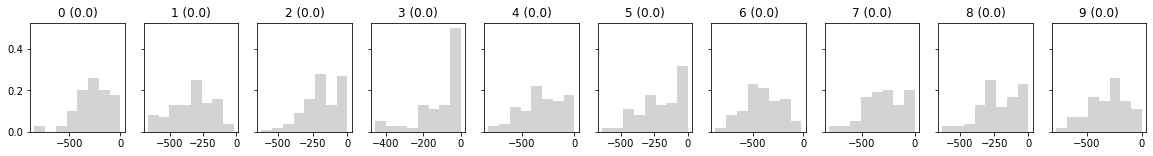

Undecided.


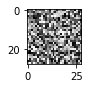

Real:  1


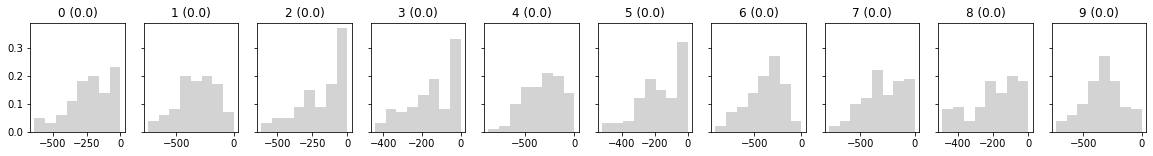

Undecided.


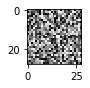

Real:  8


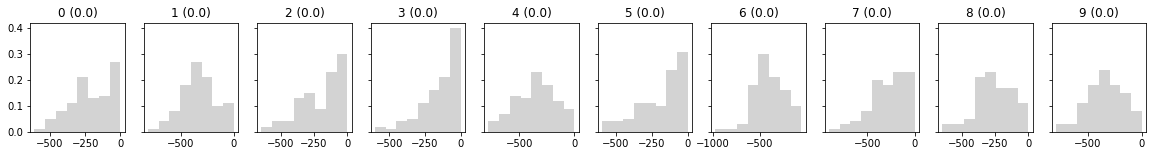

Undecided.


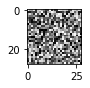

Summary
Total images:  5
Predicted for:  0


ZeroDivisionError: division by zero

In [47]:
# Testing random noise
images_random = torch.rand(5,28,28)
labels_random = torch.randint(0,10,(5,))

test_batch(images_random, labels_random)